<a href="https://colab.research.google.com/github/prthmmmmm/International-Education-Cost-Prediction/blob/main/International_Education.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import kagglehub

path = kagglehub.dataset_download("adilshamim8/cost-of-international-education")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cost-of-international-education


In [106]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [107]:
df = pd.read_csv('/kaggle/input/cost-of-international-education/International_Education_Costs.csv')
df.head()

,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.00
1,UK,London,Imperial College London,Data Science,Master,1.0,41200,75.8,1800,485,800,0.79
2,Canada,Toronto,University of Toronto,Business Analytics,Master,2.0,38500,72.5,1600,235,900,1.35
3,Australia,Melbourne,University of Melbourne,Engineering,Master,2.0,42000,71.2,1400,450,650,1.52
4,Germany,Munich,Technical University of Munich,Mechanical Engineering,Master,2.0,500,70.5,1100,75,550,0.92


In [108]:
df.shape

(907, 12)

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            907 non-null    object 
 1   City               907 non-null    object 
 2   University         907 non-null    object 
 3   Program            907 non-null    object 
 4   Level              907 non-null    object 
 5   Duration_Years     907 non-null    float64
 6   Tuition_USD        907 non-null    int64  
 7   Living_Cost_Index  907 non-null    float64
 8   Rent_USD           907 non-null    int64  
 9   Visa_Fee_USD       907 non-null    int64  
 10  Insurance_USD      907 non-null    int64  
 11  Exchange_Rate      907 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 85.2+ KB


In [110]:
duplicatevalues = df.duplicated().sum()
print("Number of duplicate values:", duplicatevalues)

Number of duplicate values: 0


In [111]:
missingvalues = df.isnull().sum()
print("Number of missing values:\n", missingvalues)

Number of missing values:
 Country              0
City                 0
University           0
Program              0
Level                0
Duration_Years       0
Tuition_USD          0
Living_Cost_Index    0
Rent_USD             0
Visa_Fee_USD         0
Insurance_USD        0
Exchange_Rate        0
dtype: int64


In [112]:
print("Country Value Counts:\n", df.Country.value_counts().head(10))

Country Value Counts:
 Country
UK             93
Australia      86
USA            78
Canada         76
Germany        33
France         27
South Korea    23
Netherlands    21
Switzerland    20
Singapore      18
Name: count, dtype: int64


In [113]:
avg_tuition = df.groupby('Country')['Tuition_USD'].mean().sort_values(ascending=False).round(2)
print('Average Tuition by Country:\n', avg_tuition.head(10))

Average Tuition by Country:
 Country
USA            47742.31
Australia      34610.47
Singapore      34172.22
UK             30341.94
Canada         29456.58
New Zealand    29333.33
UAE            24687.50
Hong Kong      22000.00
Ireland        17890.00
Lebanon        14200.00
Name: Tuition_USD, dtype: float64


In [114]:
df["Total_expenditure"]=df["Tuition_USD"] + df["Living_Cost_Index"] + df["Rent_USD"]+df["Visa_Fee_USD"]+df["Insurance_USD"]

In [115]:
print("Column Names:\n", df.columns)

Column Names:
 Index(['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years',
       'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD',
       'Insurance_USD', 'Exchange_Rate', 'Total_expenditure'],
      dtype='object')


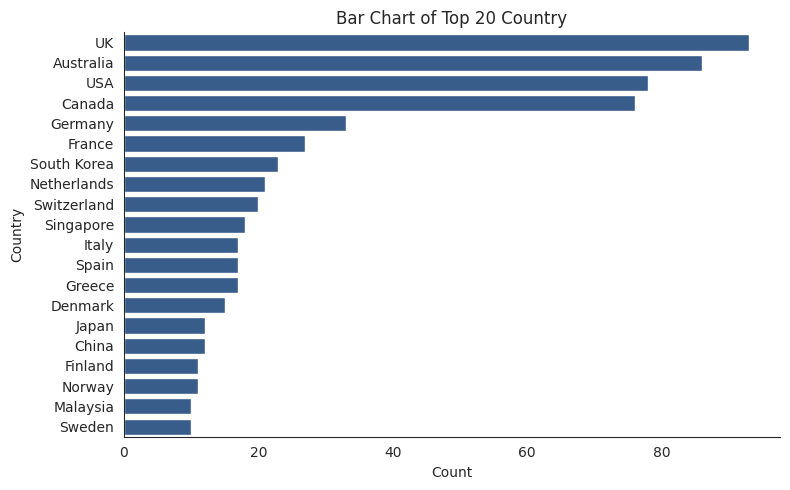

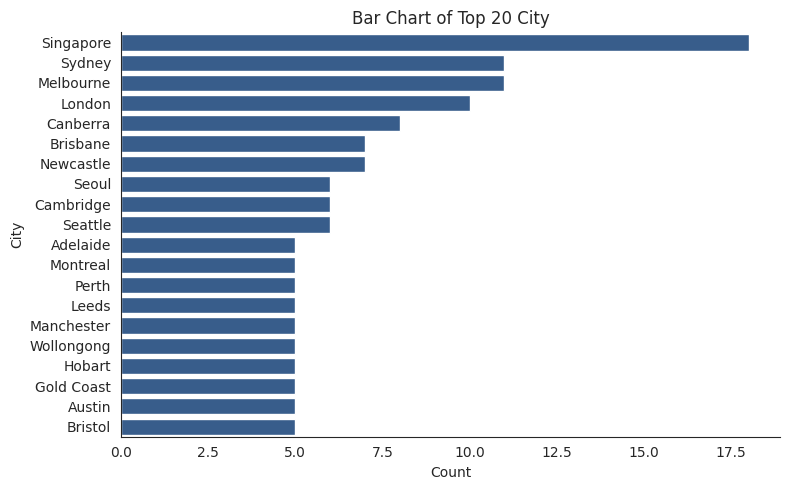

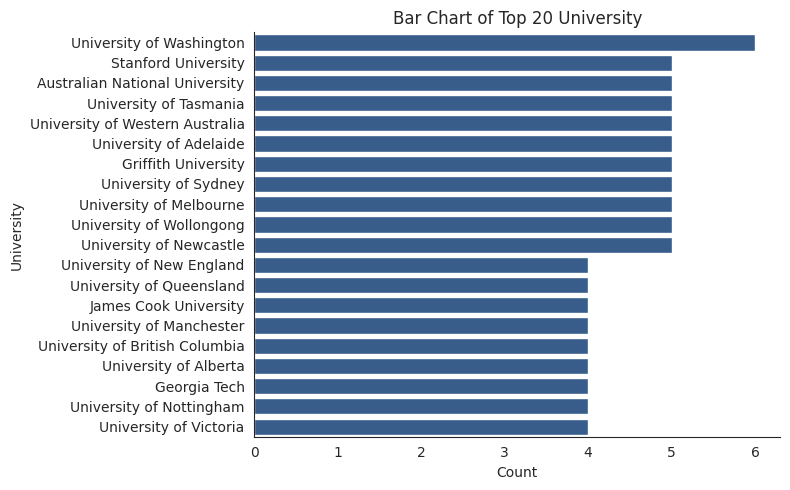

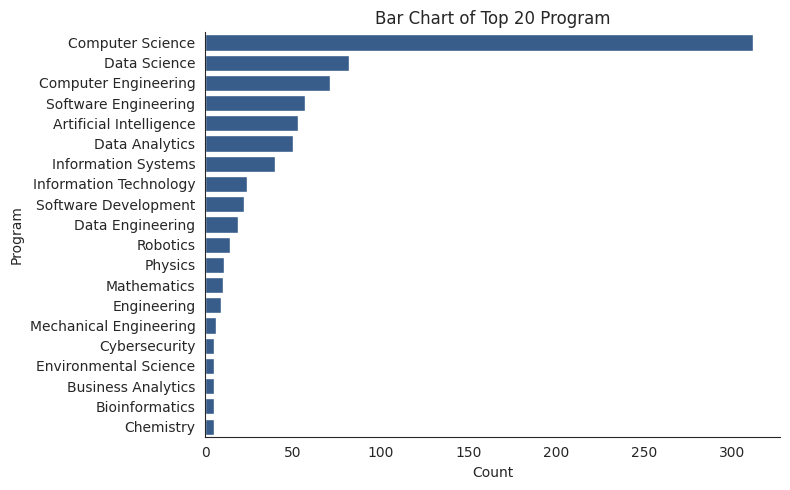

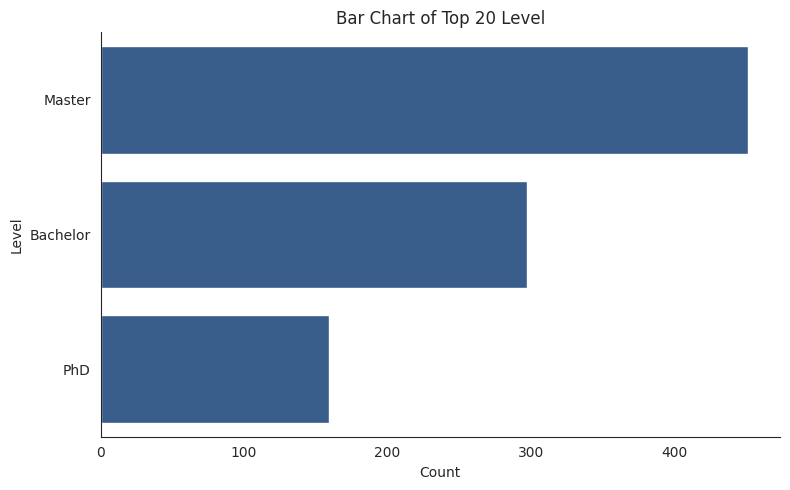

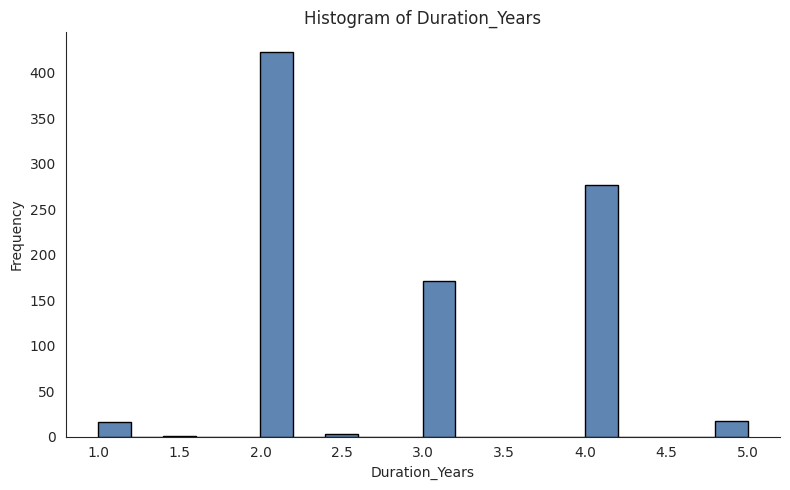

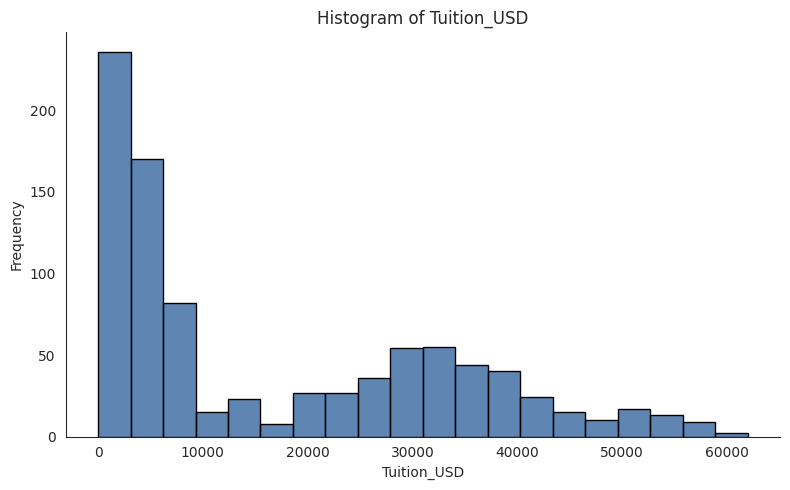

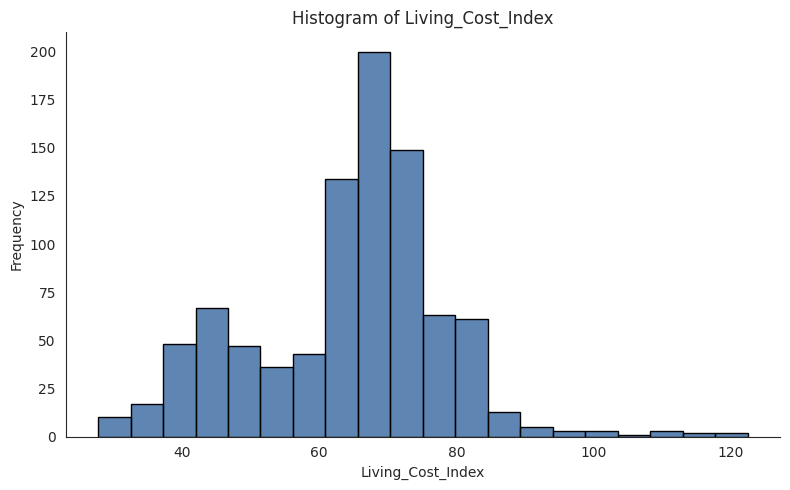

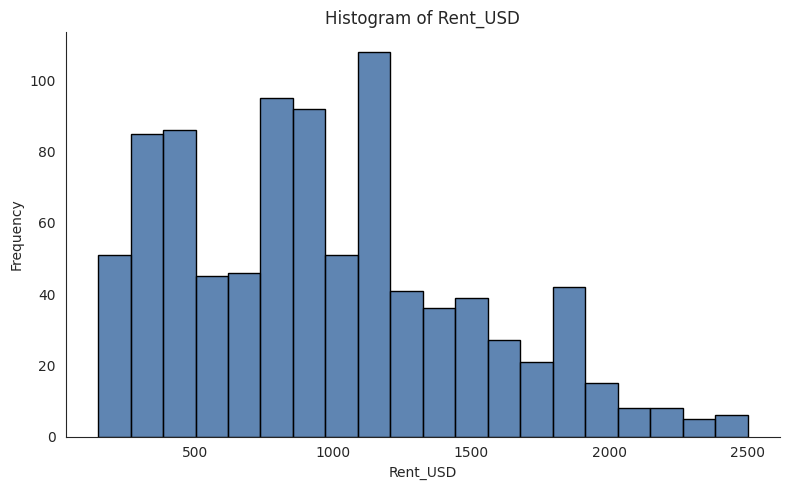

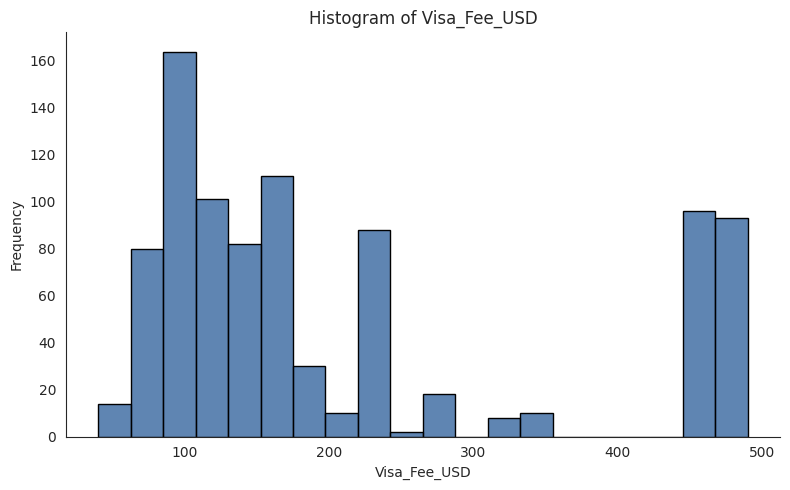

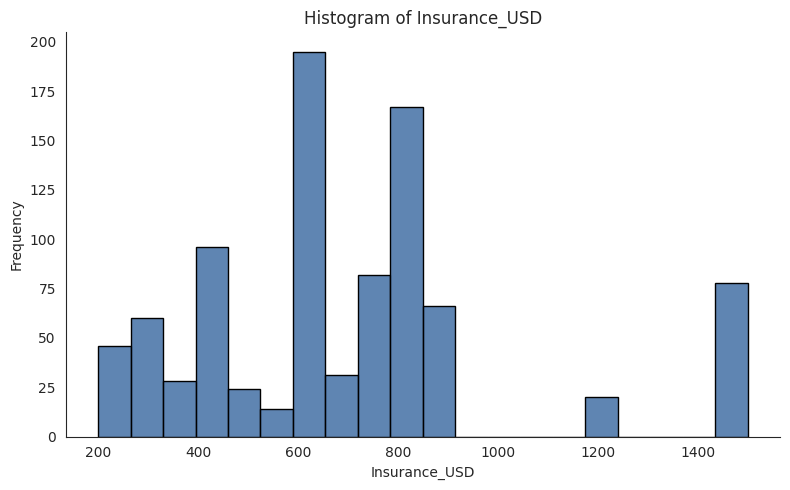

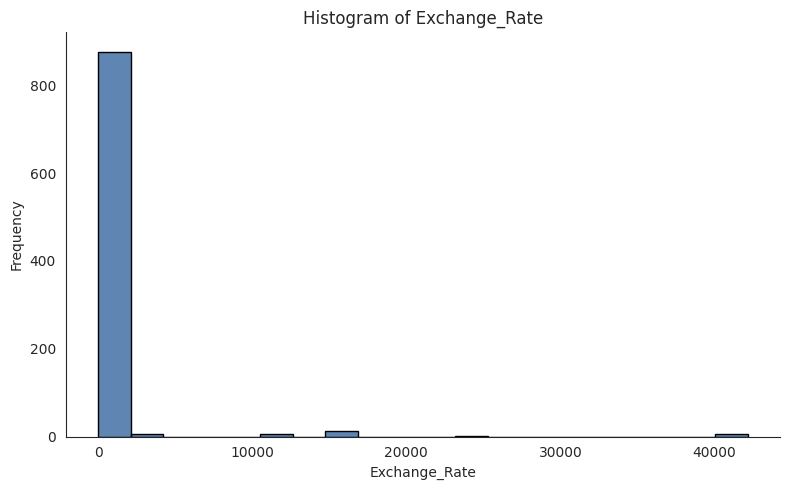

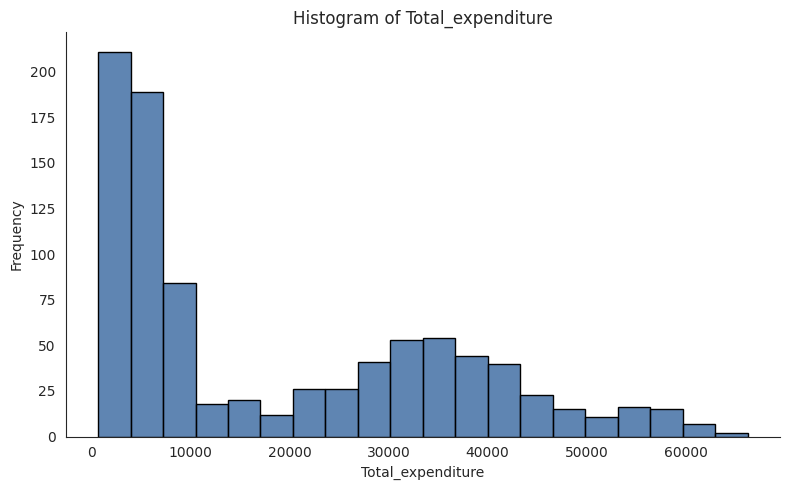

In [116]:
sns.set_style("white")
professional_color = "#2A5C99"
for col in df:
    plt.figure(figsize=(8, 5))

    if pd.api.types.is_numeric_dtype(df[col]):
        sns.histplot(df[col], bins=20, edgecolor='black', color=professional_color)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    else:
        top_categories = df[col].value_counts().head(20)
        sns.barplot(x=top_categories.values, y=top_categories.index, color=professional_color)
        plt.title(f'Bar Chart of Top 20 {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
    ax = plt.gca()
    ax.grid(False)
    for spine_name, spine in ax.spines.items():
        spine.set_visible(spine_name in ['left', 'bottom'])

    plt.tight_layout()
    plt.show()

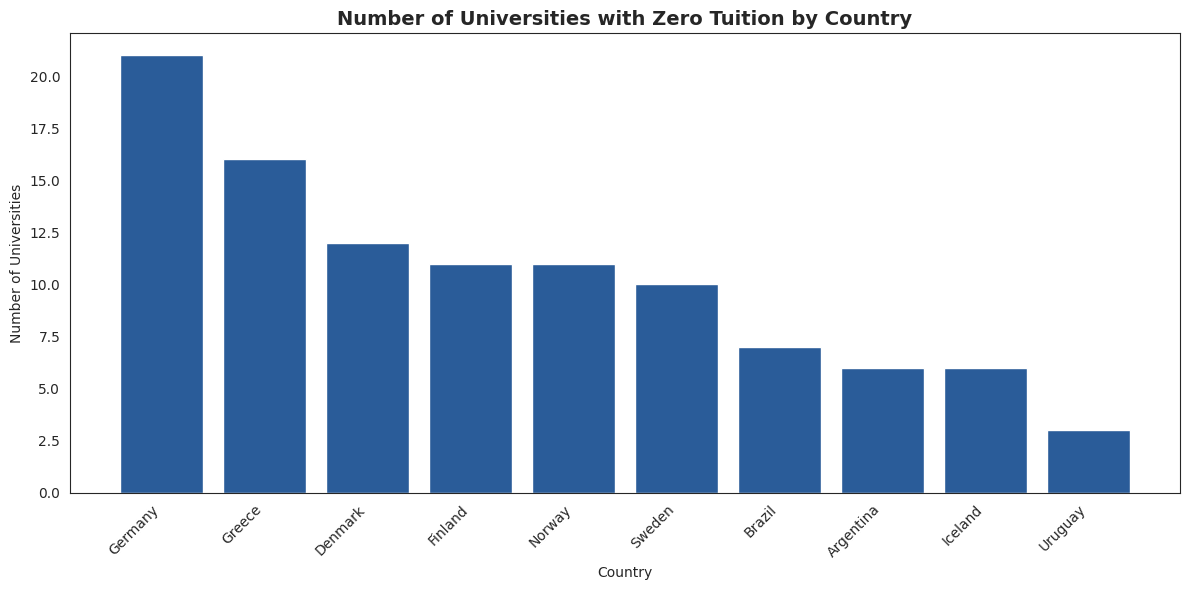

In [117]:
zero_tuition_df = df[df['Tuition_USD'] == 0]
country_counts = (
    zero_tuition_df.groupby('Country')
    .size()
    .reset_index(name='University_Count')
    .sort_values(by='University_Count', ascending=False)
    .head(20)
)
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(country_counts)), country_counts['University_Count'], color="#2A5C99")
plt.xticks(ticks=range(len(country_counts)), labels=country_counts['Country'], rotation=45, ha='right')

plt.title('Number of Universities with Zero Tuition by Country', fontsize=14, weight='bold')
plt.xlabel('Country')
plt.ylabel('Number of Universities')
plt.tight_layout()
plt.show()

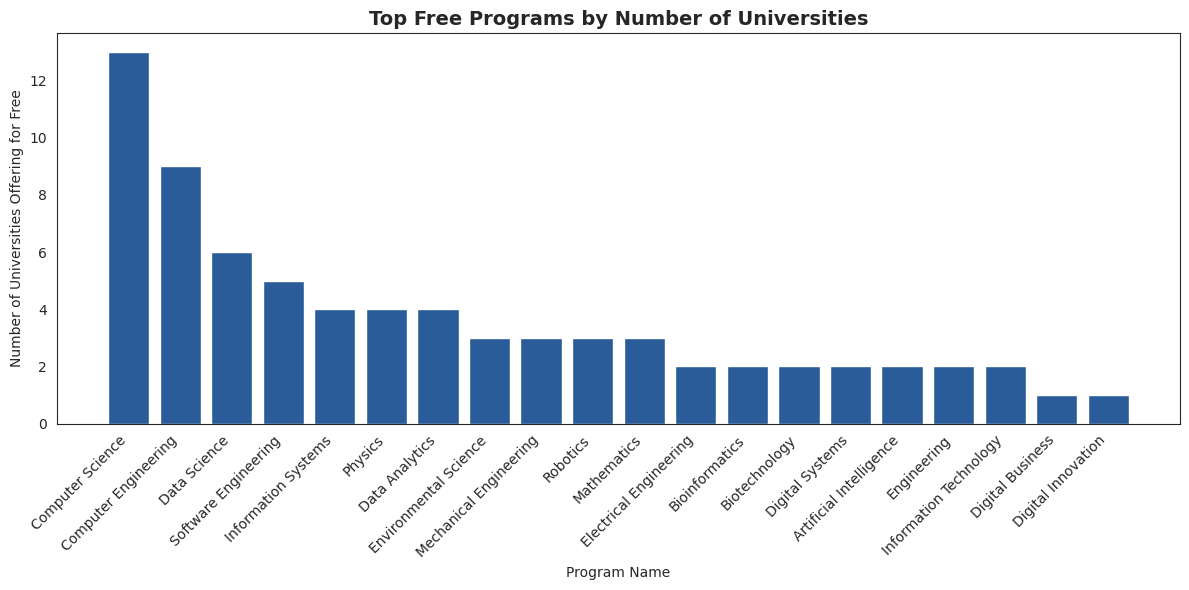

In [118]:
zero_tuition_df = df[df['Tuition_USD'] == 0]
zero_tuition_df['Program'] = zero_tuition_df['Program'].astype(str)
zero_tuition_df['University'] = zero_tuition_df['University'].astype(str)
program_university_count = (
    zero_tuition_df.groupby('Program')['University']
    .nunique()
    .reset_index(name='University_Count')
    .sort_values(by='University_Count', ascending=False)
    .head(20)
)
plt.figure(figsize=(12, 6))
plt.bar(program_university_count['Program'], program_university_count['University_Count'], color="#2A5C99")
plt.title('Top Free Programs by Number of Universities', fontsize=14, weight='bold')
plt.xlabel('Program Name')
plt.ylabel('Number of Universities Offering for Free')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

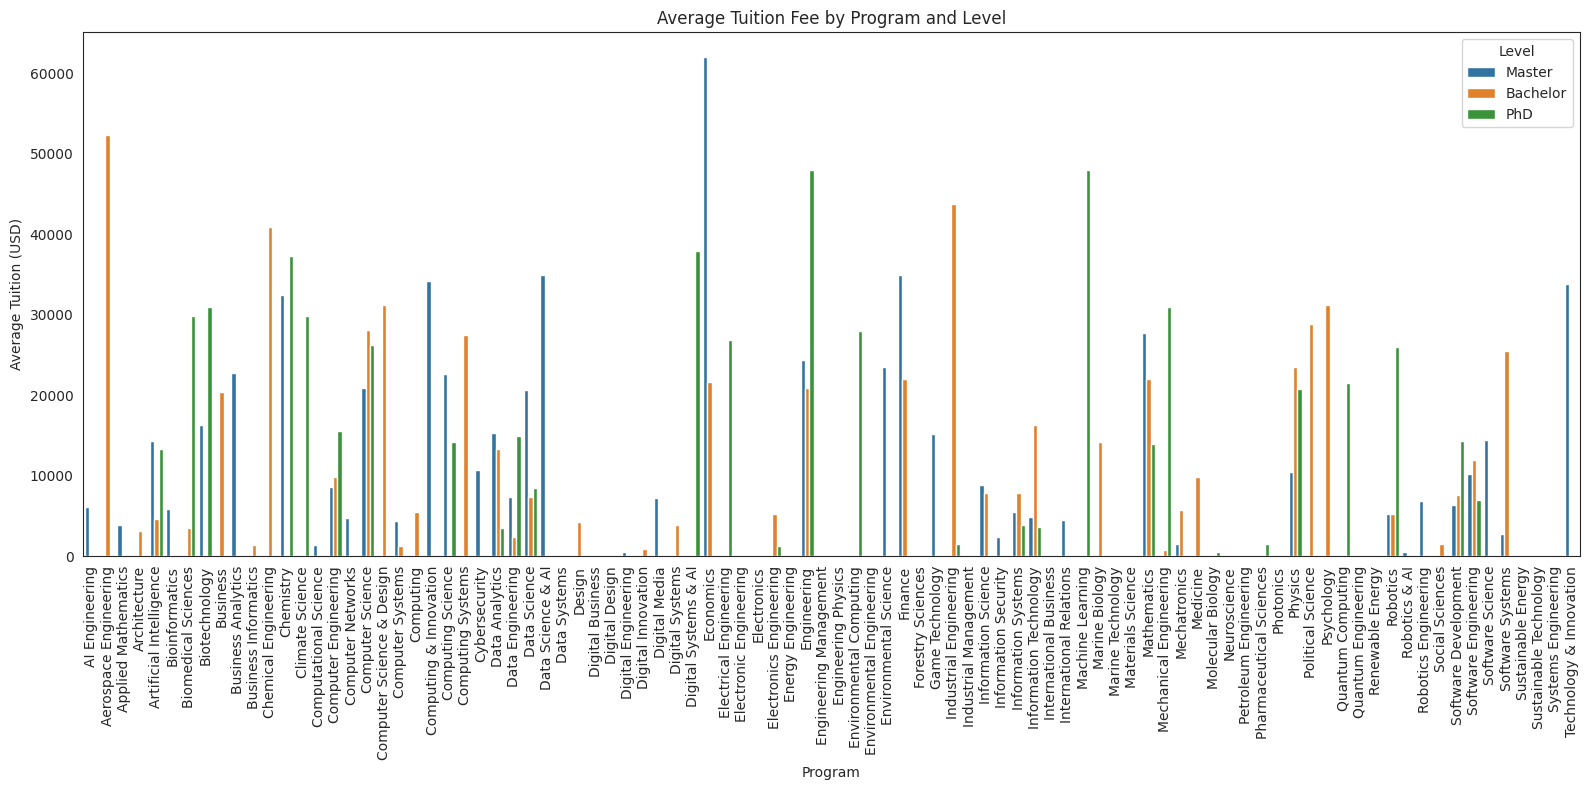

In [119]:
sns.set_style("white")
professional_color = "#2A5C99"
tuition_grouped = df.groupby(['Program', 'Level'])['Tuition_USD'].mean().reset_index()
plt.figure(figsize=(16, 8))
sns.barplot(
    data=tuition_grouped,
    x='Program',
    y='Tuition_USD',
    hue='Level',
)
plt.title('Average Tuition Fee by Program and Level')
plt.xlabel('Program')
plt.ylabel('Average Tuition (USD)')
plt.xticks(rotation=90)
plt.legend(title='Level')
plt.tight_layout()
plt.show()

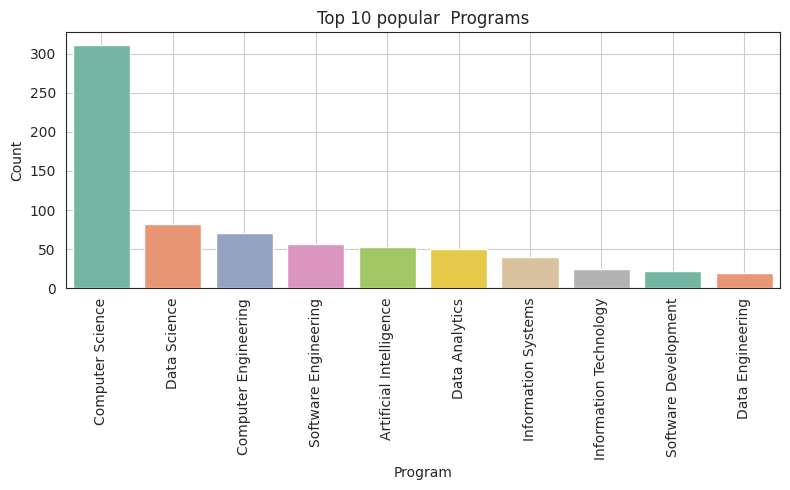

In [120]:
top_10_program=df["Program"].value_counts().head(10)
top_10_universities=df["University"].value_counts().head(10)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_10_program.index, y=top_10_program.values, palette='Set2')
plt.title('Top 10 popular  Programs')
plt.xlabel('Program')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid("off")
plt.show()

In [121]:
df.columns

Index(['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years',
       'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD',
       'Insurance_USD', 'Exchange_Rate', 'Total_expenditure'],
      dtype='object')

In [129]:
features = ["Country", "University", "Program", "Level", "Duration_Years"]
target = "Total_expenditure"
categorical = ['Country', 'University', 'Program', 'Level']
numerical = ['Duration_Years']
X = df[features]
y = df[target]

In [131]:
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numerical)
])

X_processed = preprocessor.fit_transform(X)

joblib.dump(preprocessor, "preprocessor.pkl")

from scipy.sparse import csr_matrix

if isinstance(X_processed, csr_matrix):
    X_processed = X_processed.toarray()

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class CostPredictor(nn.Module):
    def __init__(self, input_dim):
        super(CostPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CostPredictor(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.009, weight_decay=1e-4)

train_losses = []
val_losses = []
best_val_loss = np.inf
patience = 20
wait = 0

for epoch in range(300):
    model.train()
    epoch_train_loss = 0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = criterion(val_preds, y_val_tensor)

        val_pred_np = val_preds.numpy().flatten()
        y_val_np = y_val_tensor.numpy().flatten()

        r2 = r2_score(y_val_np, val_pred_np)
        mae = mean_absolute_error(y_val_np, val_pred_np)
        rmse = np.sqrt(mean_squared_error(y_val_np, val_pred_np))

    train_losses.append(epoch_train_loss / len(train_loader))
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}, Training Loss: {train_losses[-1]:.4f}, "
          f"Validation Loss: {val_loss.item():.4f}, R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        wait = 0
        torch.save(model.state_dict(), "model_weights.pth")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

Epoch 1, Training Loss: 642335444.8696, Validation Loss: 638010816.0000, R²: -1.2817, MAE: 18941.81, RMSE: 25258.88
Epoch 2, Training Loss: 620771973.5652, Validation Loss: 583565056.0000, R²: -1.0870, MAE: 17609.60, RMSE: 24157.09
Epoch 3, Training Loss: 516792544.0000, Validation Loss: 395670912.0000, R²: -0.4150, MAE: 14010.80, RMSE: 19891.48
Epoch 4, Training Loss: 304785743.6522, Validation Loss: 184590800.0000, R²: 0.3398, MAE: 11460.39, RMSE: 13586.42
Epoch 5, Training Loss: 181144326.9565, Validation Loss: 135038224.0000, R²: 0.5171, MAE: 10096.73, RMSE: 11620.60
Epoch 6, Training Loss: 132026626.0870, Validation Loss: 105565904.0000, R²: 0.6225, MAE: 8691.40, RMSE: 10274.53
Epoch 7, Training Loss: 92906973.0435, Validation Loss: 83206848.0000, R²: 0.7024, MAE: 7565.70, RMSE: 9121.78
Epoch 8, Training Loss: 64187831.3043, Validation Loss: 65869128.0000, R²: 0.7644, MAE: 6440.24, RMSE: 8115.98
Epoch 9, Training Loss: 42825218.7826, Validation Loss: 52776132.0000, R²: 0.8113, MAE